In [2]:
#!pip install portalocker>=2.0.0

In [3]:
#pip install scikit-plot

In [4]:
import re

In [5]:
from torch.utils.data import Dataset, DataLoader

In [6]:
import gensim.downloader

In [7]:
import torch

In [8]:
w2v = gensim.downloader.load('word2vec-google-news-300')

In [9]:
torch.tensor(w2v["home"]) 

tensor([-0.0118,  0.0796,  0.0168, -0.0898,  0.0864,  0.0242,  0.0255, -0.1895,
         0.1416,  0.0845,  0.1699, -0.2500, -0.0535, -0.0283,  0.0454, -0.1475,
         0.0123,  0.0564,  0.0195,  0.2158,  0.1572, -0.1592,  0.0884, -0.1060,
        -0.0041, -0.0233, -0.0493,  0.0815,  0.0381,  0.0018,  0.0552,  0.0374,
        -0.1465, -0.0381, -0.0552,  0.0114, -0.0786, -0.1494,  0.0903,  0.0371,
         0.0884, -0.0148,  0.1826,  0.0967, -0.0552,  0.1631,  0.0396,  0.1641,
         0.0840,  0.0280, -0.0344,  0.2969,  0.1406,  0.0986, -0.1846, -0.2637,
        -0.1211,  0.1826,  0.0228, -0.0425, -0.0206,  0.0825, -0.0014,  0.0225,
        -0.0762,  0.0271, -0.0471,  0.0564, -0.0025,  0.1133,  0.1289, -0.0967,
         0.0674, -0.0815, -0.1055,  0.0698, -0.0229,  0.0062,  0.0184, -0.0261,
         0.0579,  0.0771,  0.0102,  0.1797,  0.1299, -0.0471, -0.1670,  0.2471,
        -0.0303,  0.0522, -0.1475,  0.0674, -0.0562, -0.4863, -0.0077, -0.0269,
         0.0840, -0.0287, -0.0708, -0.08

In [10]:
from gensim.parsing.preprocessing import (preprocess_string,
                                          strip_tags,
                                          strip_punctuation,
                                          strip_multiple_whitespaces,
                                          strip_numeric,
                                          remove_stopwords)


# We pick a subset of the default filters,
# in particular, we do not take
# strip_short() and stem_text().
FILTERS = [strip_punctuation,
           strip_tags,
           strip_multiple_whitespaces,
           strip_numeric,
           remove_stopwords]

# See how the sentece is transformed into tokes (words)
preprocess_string('This is a "short" text!', FILTERS)

['This', 'short', 'text']

# Dataset Creation

In [11]:
import pandas as pd
#Load All_Beauty training, validation and testing split using read_csv from pandas library
#Write your code here
all_beauty_training_data = pd.read_csv(
    filepath_or_buffer='./data/All_Beauty_Split_train.csv'
)

all_beauty_test_data = pd.read_csv(
    filepath_or_buffer='data/All_Beauty_Split_test.csv'
)

all_beauty_validation_data = pd.read_csv(
    filepath_or_buffer='data/All_Beauty_Split_val.csv'
)

In [12]:
#Load Gift Card training, validation and testing split using read_csv from pandas library
#Write your code here
gift_cards_training_data = pd.read_csv(
    filepath_or_buffer='./data/Gift_Cards_Split_train.csv'
)

gift_cards_test_data = pd.read_csv(
    filepath_or_buffer='data/Gift_Cards_Split_test.csv'
)

gift_cards_validation_data = pd.read_csv(
    filepath_or_buffer='data/Gift_Cards_Split_val.csv'
)

In [13]:
#Concatenate the two splits to get a combined dataframe
#Write your code here
trainig_data = pd.concat([all_beauty_training_data, gift_cards_training_data], ignore_index=True)
test_data = pd.concat([all_beauty_test_data, gift_cards_test_data], ignore_index=True)
validation_data = pd.concat([all_beauty_validation_data, gift_cards_validation_data], ignore_index=True)

In [14]:
#Creating dataset class
class reviews(Dataset):
    def __init__(self,split):
        super(reviews,self).__init__()

        if split == 'train':
        #Give train dataframe
            df_data = trainig_data
        elif split == 'val':
        #Give validation dataframe
            df_data = validation_data
        elif split == 'test':
        #Give test dataframe
            df_data = test_data
        else:
            raise Exception(f"wrong split: {split}")
        #List for containing (input,output) pairs
        self.data = []
        #Make a list of ratings from df_data
        ratings = df_data['Rating']
        #Make a list of reviews from df_data
        text = df_data['Text']

        if len(text) == 0:
            print("0")

        for i in range(len(text)):
            #Creating list of tokens for each review
            txt = preprocess_string(text[i], filters=FILTERS)
            #Appending (input,output) pairs to list
            self.data.append([txt,ratings[i]])

    def vectorise(self,txt):
        #Final tensor
        X_tensor = torch.zeros(300)
        l=0
        for i in txt:
          #Check if the word is in the vocabulary of word2vec
          if i in w2v:
            l = l+1
            #If so add it to the X_tensor
            X_tensor += torch.tensor(w2v[i])
        #Divide X_tensor by number of vectors that were added. This is called mean pooling
        if l > 0:
            X_tensor = X_tensor / l
        return X_tensor

    def __getitem__(self,index):
        sent_tensor = self.vectorise(self.data[index][0])
        return [sent_tensor,(self.data[index][1]-1)]
    def __len__(self):
        return len(self.data)

In [15]:
import torch

target_classes = ["1", "2", "3", "4", "5"]

train_dataset = reviews("train")
val_dataset = reviews("val")
test_dataset = reviews("test")

train_loader = DataLoader(train_dataset, batch_size=128)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader  = DataLoader(test_dataset, batch_size=128)

In [16]:
for X, Y in train_loader:
    print(X.shape, Y.shape)
    break

torch.Size([128, 300]) torch.Size([128])


# Model Training

In [17]:
from torch import nn
from torch.nn import functional as F

#Embedding dimension of Word2vec
embed_len = 300

#Create a Neural Network for mapping the reviews to probabilities of different ratings
class EmbeddingClassifier(nn.Module):
    def __init__(self):
        super(EmbeddingClassifier, self).__init__()
        #Create a Neural Network with input dimension embed_len, hidden dimensions 256,128,64 and output dimension the length of target class.
        #Use Relu as the activation function between each layer.
        self.seq = nn.Sequential(
            nn.Linear(embed_len, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, len(target_classes))
        )

    def forward(self, X_batch):
        return self.seq(X_batch)

In [18]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import gc

def CalcValLossAndAccuracy(model, loss_fn, val_loader):
    with torch.no_grad():
        Y_shuffled, Y_preds, losses = [],[],[]
        for X, Y in val_loader:
            #Predict output probabilities for all target classes for input X
            preds = model(X)
            loss = loss_fn(preds, Y.long())
            losses.append(loss.item())

            Y_shuffled.append(Y)
            #Get the predicted class from the output probabilities: The class with the highest probability. Append to Y_preds list(use argmax)
            Y_preds.append(torch.argmax(preds, dim=1))

        Y_shuffled = torch.cat(Y_shuffled)
        Y_preds = torch.cat(Y_preds)

        print("Valid Loss : {:.3f}".format(torch.tensor(losses).mean()))
        print("Valid Acc  : {:.3f}".format(accuracy_score(Y_shuffled.detach().numpy(), Y_preds.detach().numpy())))

def TrainModel(model, loss_fn, optimizer, train_loader, val_loader, epochs=10):
    for i in range(1, epochs+1):
        losses = []
        for X, Y in tqdm(train_loader):
            #Predict output probabilities for all target classes for input X″
            Y_preds = model(X)
            loss = loss_fn(Y_preds, Y.long())
            losses.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if i%5==0:
            print("Train Loss : {:.3f}".format(torch.tensor(losses).mean()))
            CalcValLossAndAccuracy(model, loss_fn, val_loader)

In [19]:
from torch.optim import Adam

epochs = 25
learning_rate = 1e-3

loss_fn = nn.CrossEntropyLoss()
embed_classifier = EmbeddingClassifier()
optimizer = Adam(embed_classifier.parameters(), lr=learning_rate)

In [20]:
TrainModel(embed_classifier, loss_fn, optimizer, train_loader, test_loader, epochs)

100%|██████████| 38/38 [00:00<00:00, 68.68it/s]


Train Loss : 0.668
Valid Loss : 0.240
Valid Acc  : 0.928


100%|██████████| 38/38 [00:00<00:00, 68.76it/s]


Train Loss : 0.633
Valid Loss : 0.231
Valid Acc  : 0.928


100%|██████████| 38/38 [00:00<00:00, 71.01it/s]


Train Loss : 0.590
Valid Loss : 0.218
Valid Acc  : 0.928


100%|██████████| 38/38 [00:00<00:00, 69.85it/s]


Train Loss : 0.553
Valid Loss : 0.200
Valid Acc  : 0.928


100%|██████████| 38/38 [00:00<00:00, 69.05it/s]

Train Loss : 0.510
Valid Loss : 0.171
Valid Acc  : 0.928


# Evaluation

In [23]:
def MakePredictions(model, loader):
    Y_shuffled, Y_preds = [], []
    for X, Y in loader:
        preds = model(X)
        Y_preds.append(preds)
        Y_shuffled.append(Y)
    gc.collect()
    Y_preds, Y_shuffled = torch.cat(Y_preds), torch.cat(Y_shuffled)

    return Y_shuffled.detach().numpy(), F.softmax(Y_preds, dim=-1).argmax(dim=-1).detach().numpy()

Y_actual_val, Y_preds_val = MakePredictions(embed_classifier, val_loader)

In [28]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

#Write code to get full classification report and print a confusion matrix for validation set
acc = accuracy_score(Y_actual_val, Y_preds_val)
report = classification_report(Y_actual_val, Y_preds_val)
conf = confusion_matrix(Y_actual_val, Y_preds_val)

print(acc)
print(report)
print(conf)

0.7448036951501155
              precision    recall  f1-score   support

         0.0       0.33      0.07      0.12        14
         1.0       0.00      0.00      0.00        19
         2.0       0.75      0.06      0.11        53
         3.0       0.50      0.01      0.01       140
         4.0       0.75      1.00      0.86       640

    accuracy                           0.74       866
   macro avg       0.47      0.23      0.22       866
weighted avg       0.68      0.74      0.64       866

[[  1   0   0   0  13]
 [  1   0   1   1  16]
 [  1   0   3   0  49]
 [  0   0   0   1 139]
 [  0   0   0   0 640]]


/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

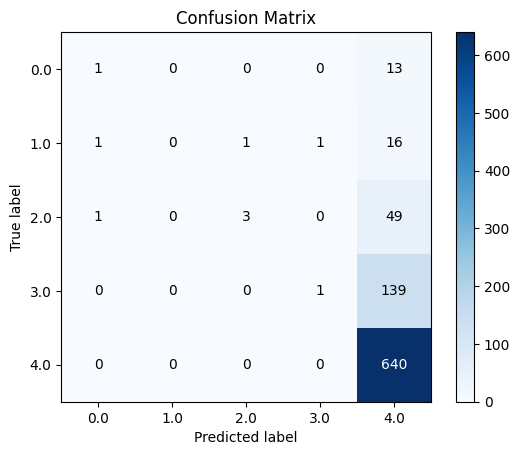

In [30]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

#Plot a confusion matrix for the validation set
skplt.metrics.plot_confusion_matrix(
    Y_actual_val, Y_preds_val
)

In [32]:
Y_actual_test, Y_preds_test = MakePredictions(embed_classifier, test_loader)

In [33]:
#Write code to get full classification report and print a confusion matrix for test set
acc = accuracy_score(Y_actual_test, Y_preds_test)
report = classification_report(Y_actual_test, Y_preds_test)
conf = confusion_matrix(Y_actual_test, Y_preds_test)

print(acc)
print(report)
print(conf)

0.9280575539568345
              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00         2
         1.0       0.00      0.00      0.00         5
         2.0       0.00      0.00      0.00         5
         3.0       0.00      0.00      0.00         8
         4.0       0.93      1.00      0.97       258

    accuracy                           0.93       278
   macro avg       0.19      0.20      0.19       278
weighted avg       0.87      0.93      0.90       278

[[  0   0   0   0   2]
 [  1   0   0   1   3]
 [  0   0   0   0   5]
 [  0   0   0   0   8]
 [  0   0   0   0 258]]


/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/julian.steiner/.virtualenvs/ethics-4-nlp/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf

<Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

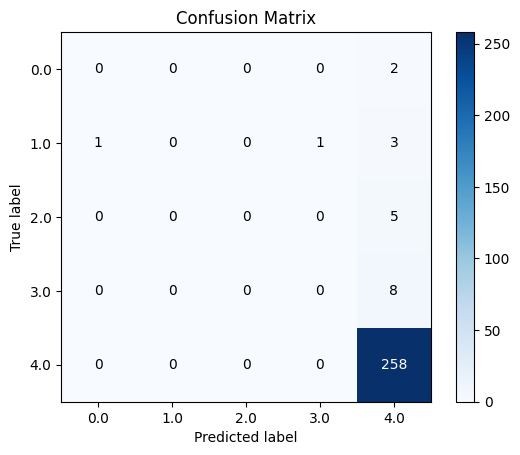

In [34]:
#Plot a confusion matrix for the test set
skplt.metrics.plot_confusion_matrix(
    Y_actual_test, Y_preds_test
)